In [ ]:
#allows any changes on external files to be loaded on code run.
%load_ext autoreload
%autoreload 2

# Dummy Function

PLOT SLICES
d (200, 2)
d (200, 2)


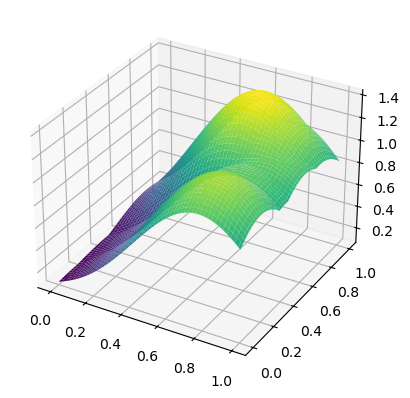

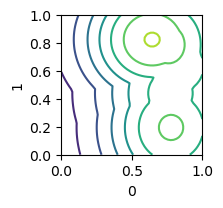

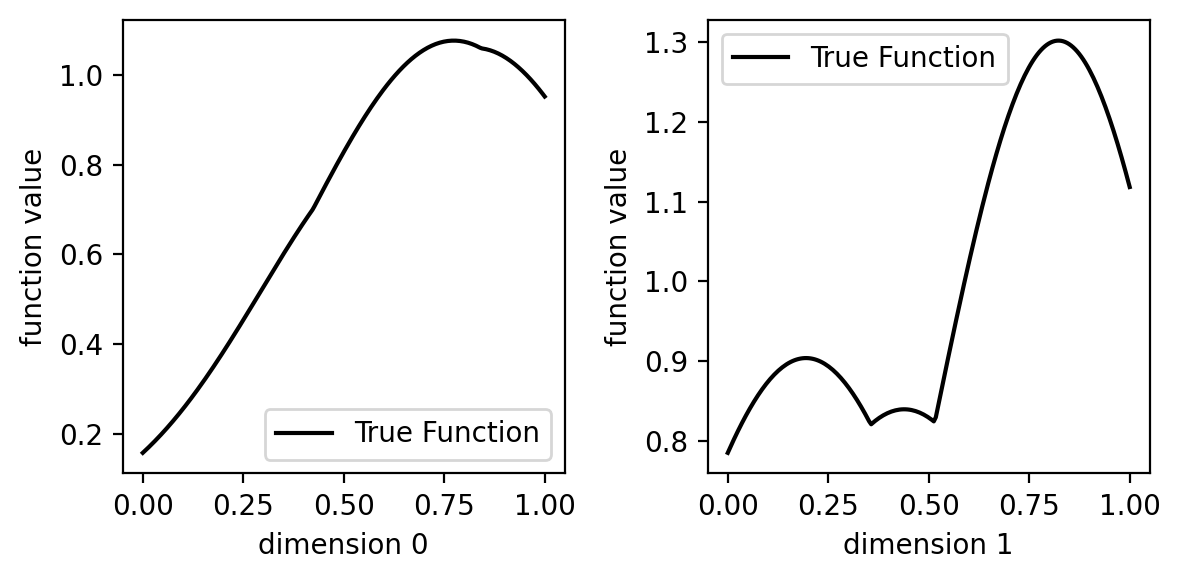

In [4]:
import sys
import matplotlib.pyplot as plt
import os
sys.path.append(os.path.join(os.curdir,'..'))
from GENE_ML.gene_ml.test_functions.max_of_many_gaussians import MaxOfManyGaussians

num_dim = 2
confine = 0#only needed to forse the mean to be samples in a smaller space than the functions bounds
mean_bounds = [(0+confine,1-confine) for i in range(num_dim)]
bounds = [(0,1) for i in range(num_dim)]
std_bounds=(0.1,0.15)
# std_bounds=(0.008,0.01)

num_gaussians = 5
mmg = MaxOfManyGaussians(num_dim, num_gaussians, bounds, mean_bounds, std_bounds, seed=42)
mmg.plot_2D_of_many(which2=(0,1))#you can try changing which two. It specifies which dimensions to plot
mmg.plot_matrix_contour()
mmg.plot_slices()


# Ionut Dimensionally Adaptive

In [2]:
import numpy as np
import sys
sys.path.append('/home/djdaniel/GENE_UQ/GENE_ML/sensitivity-driven-sparse-grid-approx')
from sg_lib.grid.grid import *
from sg_lib.algebraic.multiindex import *
from sg_lib.operation.interpolation_to_spectral import *
from sg_lib.adaptivity.spectral_scores import *

# discrete approximation of the Pearson correlation coefficient
# see the Peherstorfer, Willcox, Gunzburger 2016 paper for the formula
def compute_corr_coeff(hi_fi_evals, lo_fi_evals):

	mean_hi_fi = np.mean(hi_fi_evals)
	mean_lo_fi = np.mean(lo_fi_evals)

	std_hi_fi = np.std(hi_fi_evals, ddof=1)
	std_lo_fi = np.std(lo_fi_evals, ddof=1)

	rho_12 = np.sum(np.array([(hi_fi_eval - mean_hi_fi)*(lo_fi_eval - mean_lo_fi) \
				for hi_fi_eval, lo_fi_eval in zip(hi_fi_evals, lo_fi_evals)]))/(std_hi_fi*std_lo_fi*(len(hi_fi_evals) - 1.))

	return rho_12

# high-fidelity model for this test
def hi_fi_model(x):
	test = np.cos(np.pi + 1.0*x[0] + 0.55*x[1] + 0.8*x[2] + 0.1*x[3]) + 1.0

	return test
    
if __name__ == '__main__':

	# problem setup
	dim = 4

	# sparse grid setup
	# here, we consider a uniform input distribution, thus the bounds are [0, 1]^dim
	left_bounds 	= np.zeros(dim)
	right_bounds 	= np.ones(dim)
	# sparse grids always begin at level 1
	grid_level 		= 1
	# not important; keep it 1 for interpolation
	level_to_nodes 	= 1
	# probability density function; in this case, we have a uniform density in [0, 1]^dim
	# since the stochastic inputs are independent, it has a product structure
	weights 		= [lambda x: 1. for i in range(dim)]

	# tolerance used in the adaptive algorithm
	tols 		= 1e-6*np.ones(dim + 1)
	# maximum level reachable by the sparse grid
	max_level 	= 20

	# first multiindex in K is (1, 1, ... , 1)
	init_multiindex = np.ones(dim, dtype=int)
	
	# create objects to do sensitivity-driven adaptve sparse grid interpolation

	# grid object
	Grid_obj 				= Grid(dim, grid_level, level_to_nodes, left_bounds, right_bounds, weights)
	# multiindex object
	Multiindex_obj 			= Multiindex(dim)

	# interpolation object
	InterpToSpectral_obj 	= InterpolationToSpectral(dim, level_to_nodes, left_bounds, right_bounds, weights, max_level, Grid_obj)

	# adaptivity object; the most important thing is the refinement indicator; see the paper
	# see also the implementation
	Adaptivity_obj 			= SpectralScores(dim, tols, init_multiindex, max_level, level_to_nodes, InterpToSpectral_obj)

	# add initial multiindex to the multiindex set, aka, K = {(1, 1, ..., 1)}
	init_multiindex_set = Multiindex_obj.get_std_total_degree_mindex(grid_level)
	# take the grid points corresponding to the first multiindex
	init_grid_points 	= Grid_obj.get_std_sg_surplus_points(init_multiindex_set)
	init_no_points 		= Grid_obj.get_no_fg_grid_points(init_multiindex_set)

	InterpToSpectral_obj.get_local_global_basis(Adaptivity_obj)

	# begin the adaptive process

	# first step, do the initial subspace which contains 1 point
	for sg_point in init_grid_points:
		sg_val 		= hi_fi_model(sg_point)
		InterpToSpectral_obj.update_sg_evals_all_lut(sg_point, sg_val)

	InterpToSpectral_obj.update_sg_evals_multiindex_lut(init_multiindex, Grid_obj)
	
	# adaptivity begins here; see paper, especially the algorithms, for more details
	Adaptivity_obj.init_adaption()

	prev_len 		= len(init_no_points)
	no_adapt_steps 	= 0
	total_len 		= 1
	while not Adaptivity_obj.stop_adaption:
		no_adapt_steps += 1

		new_multiindices = Adaptivity_obj.do_one_adaption_step_preproc()

		for multiindex in new_multiindices:
			new_grid_points = Grid_obj.get_sg_surplus_points_multiindex(multiindex)
			total_len 		+= len(new_grid_points)

			for sg_point in new_grid_points:
				sg_val = hi_fi_model(sg_point)
			
				InterpToSpectral_obj.update_sg_evals_all_lut(sg_point, sg_val)

			InterpToSpectral_obj.update_sg_evals_multiindex_lut(multiindex, Grid_obj)
			
		Adaptivity_obj.do_one_adaption_step_postproc(new_multiindices)
		Adaptivity_obj.check_termination_criterion()

	print('adaptivity done after', str(no_adapt_steps), 'steps')
	print('grid size =', total_len, 'sparse grid points')

	InterpToSpectral_obj.get_local_global_basis(Adaptivity_obj)

	adapt_sg_lo_fi_model = lambda x: InterpToSpectral_obj.eval_operation_sg(Adaptivity_obj.multiindex_set, x)	

	# here, we compute the Pearson correlation coefficient between the high- and low-fidelity model, which will be relevant for doing  MFMC
	np.random.seed(9812788)
	corr_coeff_no_samples 	= 1000
	corr_coeff_samples 		= np.random.uniform(0, 1, size=(corr_coeff_no_samples, dim))

	f_eval = [hi_fi_model(sample) for sample in corr_coeff_samples]

	f_approx = np.zeros(corr_coeff_no_samples)
	for i, sample in enumerate(corr_coeff_samples):
		f_approx[i] = adapt_sg_lo_fi_model(sample)

	corr_coeff = compute_corr_coeff(f_eval, f_approx)

	print('corr coeff(hi-fi model, lo-fi surrogate) = ',corr_coeff)

ModuleNotFoundError: No module named 'onedim'